In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [76]:
fpath=r"D:\Code Working Area\Jupyter\knowledge-graph-for-stakeholder-risks-detection-in-mega-infrastructure-projects\ExcelData\Result_0.001_0.5.csv"
used=pd.read_csv(fpath)

In [77]:
# used.columns=["p1", "p2", "probability"]
# used.drop(columns=['ind'], inplace=True)
# used=used[used.p2!="{'ON'}"]
def cleanw(args:str):
    args=args[2:-2]
    args=args.replace("'", "")
    return args

In [78]:
used.p1=used.p1.apply(cleanw)
used.p2=used.p2.apply(cleanw)
used

,p1,p2,probability
0,Change risk,Climate,0.875862
1,Departments of Transportation,State,0.775641
2,Social Implications,PURPOSE,0.742331
3,NPV,NET,0.817073
4,QRA,Quantitative risk,0.826816
...,...,...,...
517,"Social, Energy",Economic,0.511384
518,"Social, Energy, ON",Economic,0.526549
519,"Social, COST",Economic,0.513554
520,"Social, COST, ON",Economic,0.510000


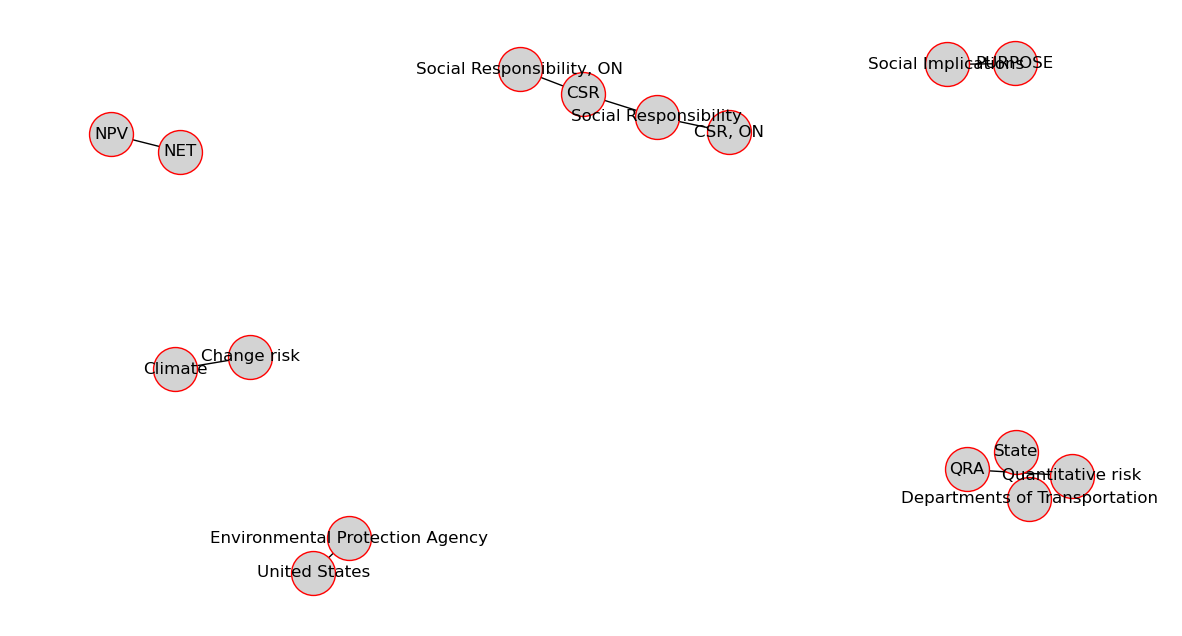

In [95]:
temp=used.iloc[0:10]
fig, ax = plt.subplots(figsize=(15,8))
G = nx.from_pandas_edgelist(temp, "p1", "p2", create_using=nx.Graph())
pos = nx.spring_layout(G)

nx.draw(G, with_labels=True, node_color='lightgray',edgecolors='red',node_size=1000)
# nx.draw_networkx_labels(G, pos, font_size=10);

In [93]:
pos

{'Change risk': array([ 0.6963965 , -0.46767173]),
 'Climate': array([ 0.61163592, -0.49625648]),
 'Departments of Transportation': array([-0.9436417 ,  0.00801442]),
 'State': array([-0.95077813, -0.08115433]),
 'Social Implications': array([ 0.23796038, -1.        ]),
 'PURPOSE': array([ 0.15188671, -0.97530767]),
 'NPV': array([0.0649221 , 0.92398829]),
 'NET': array([-0.02380155,  0.912649  ]),
 'QRA': array([-0.60359508,  0.64701574]),
 'Quantitative risk': array([-0.6803985 ,  0.71595731]),
 'Environmental Protection Agency': array([-0.51146907, -0.83783585]),
 'United States': array([-0.44048725, -0.75483398]),
 'CSR': array([0.52827067, 0.31883794]),
 'Social Responsibility': array([0.63741783, 0.39714499]),
 'Social Responsibility, ON': array([0.49018855, 0.22804036]),
 'CSR, ON': array([0.73549261, 0.46141198])}

,p1,p2
2,{'Social Implications'},{'PURPOSE'}
3,{'NPV'},{'NET'}
4,{'QRA'},{'Quantitative risk'}
5,{'Environmental Protection Agency'},{'United States'}
6,{'CSR'},{'Social Responsibility'}
...,...,...
515,"{'Social', 'GROWTH', 'ON'}",{'Economic'}
516,"{'Social', 'EFFICIENT'}",{'Economic'}
517,"{'Social', 'Energy'}",{'Economic'}
518,"{'Social', 'Energy', 'ON'}",{'Economic'}
